# 4. Nuclear phylogenomics
## 4.1 Determine number of incongruent phylogenetic patterns in orthology clusters

This will compute a raxml tree for each orthology cluster, compute pairwise distances among the trees and run a metric MDS to check how many clusters of trees there are. Only one tight cluster is observed.

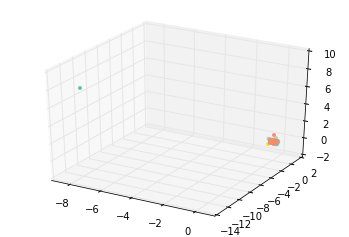

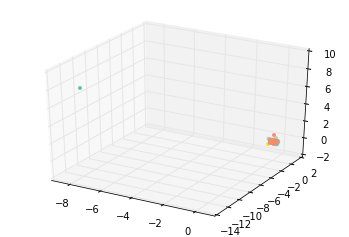

In [56]:
import treeCl, glob, os

# All the orthology cluster in which at lease three reference samples
# have two copies, and all the reference samples have at least one copy
alndir = './orthofinder/all_inputs/Results_Jul02/I2_3X2_gt0.7_st0.001_alns_1_4'

for f in glob.glob(alndir+'/*.fasta'):
    newf = f.replace('RAxML_bestTree.','').replace('284421467500872.59_','')
    os.rename(f, newf)

# Compute gene trees
c = treeCl.Collection(input_dir=alndir, file_format='fasta')
c.calc_trees(executable='raxmlHPC-PTHREADS',  # specify raxml binary to use
             threads=14,  # use multithreaded raxml
             model='GTRGAMMA',  # this model of evolution
             fast_tree=False)

# Compute pairwise distance between gene trees using a 
# weighted robinson foulds distance
dm = c.get_inter_tree_distances('wrf')

# Metric MDS, impose 10 clusters
mdsclust = treeCl.MultidimensionalScaling(dm)
mds_partitions = mdsclust.cluster(10)
mds_mmds = mdsclust.dm.embedding(3, 'mmds')
%matplotlib inline
treeCl.plotter.plot_embedding(mds_mmds,
                              partition=mds_partitions, 
                              add_sphere=False, 
                              legend=False,
                              outfile=alndir + '/metric_mds.png')

## 4.2 Automatically detect the number of clusters using DBS
With esp ranging from 0.01 to 0.75, only the esp == 0.1 produces more than one cluster. One cluster with 406 trees and another with 39 trees.

In [40]:
aclust = treeCl.Automatic(dm)
# esp was 0.75 - 0.01. Only esp == 0.1 gives more than one cluster.
dbscan_partitions = aclust.dbscan(eps=0.1, min_samples=3)
print 'dbs_clusters', dbscan_clustlengths

dbs_clusters [406, 39]


## 4.3 Reconstruct a supermatrix tree for each DBS cluster
The two trees have the same topology

In [4]:
# compute the trees
raxml = treeCl.tasks.RaxmlTaskInterface()
sc = treeCl.Scorer(c, cache_dir = alndir.replace('alns','cache_alignments'),
                   task_interface=raxml) 
sc.write_partition(dbscan_partitions)
results = sc.analyse_cache_dir(executable='raxmlHPC-PTHREADS', threads=14)

# Get a list of the loci in each cluster
loci = sc.get_partition_members(dbscan_partitions)
with open(alndir+'/loci.txt','wt') as hndl:
    hndl.write(str(loci))

# Get trees for each cluster
trees = sc.get_partition_trees(dbscan_partitions)

from reprophylodev import *

for i in range(len(dbscan_partitions)):
    
    title = "Inflation 2, no CDS align, 3X2, gt 0.7, st 0.001, cluster %i, %i loci" % (i, dbscan_clustlengths[i])

    ns = NodeStyle()
    ns['size'] = 0
    ns['vt_line_width'] = 2
    ns['hz_line_width'] = 2
    ts = TreeStyle()
    ts.title.add_face(TextFace(title, fsize=20), column=0)
    ts.show_leaf_name=False

    colors = {
        'Minc':'Red',
        'Mjav':'Blue',
        'Mflo':'Black',
        'Mare':'Green',
        'Ment':'gray'
    }

    t = Tree(trees[i])
    t.dist = 0
    try:
        t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
    except:
        t.set_outgroup('MentL30_1')

    for n in t.traverse():
        if n.is_leaf():
            text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD17')

            fgcolor = 'black'
            try:
                fgcolor=colors[text[:4]]
            except:
                fgcolor = 'black'

            n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                       0,position='branch-right')

        n.set_style(ns)
    t.render(alndir+'/cluster_%i.png'%i,tree_style=ts, dpi=300)
    #t.render('%%inline',tree_style=ts, dpi=300)

Cache dir analysis: 2 of 2 |##############| Elapsed Time: 0:02:00 Time: 0:02:00


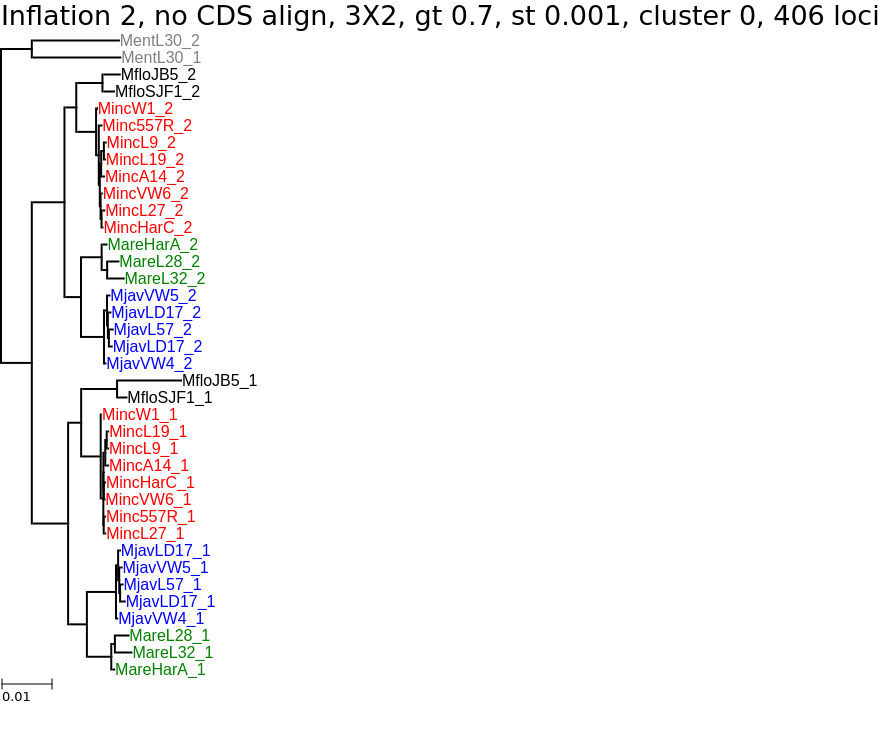

In [5]:
from IPython.display import Image
Image('./orthofinder/all_inputs/Results_Jul02/I2_3X2_gt0.7_st0.001_alns_1_4/cluster_0.png', width=800)

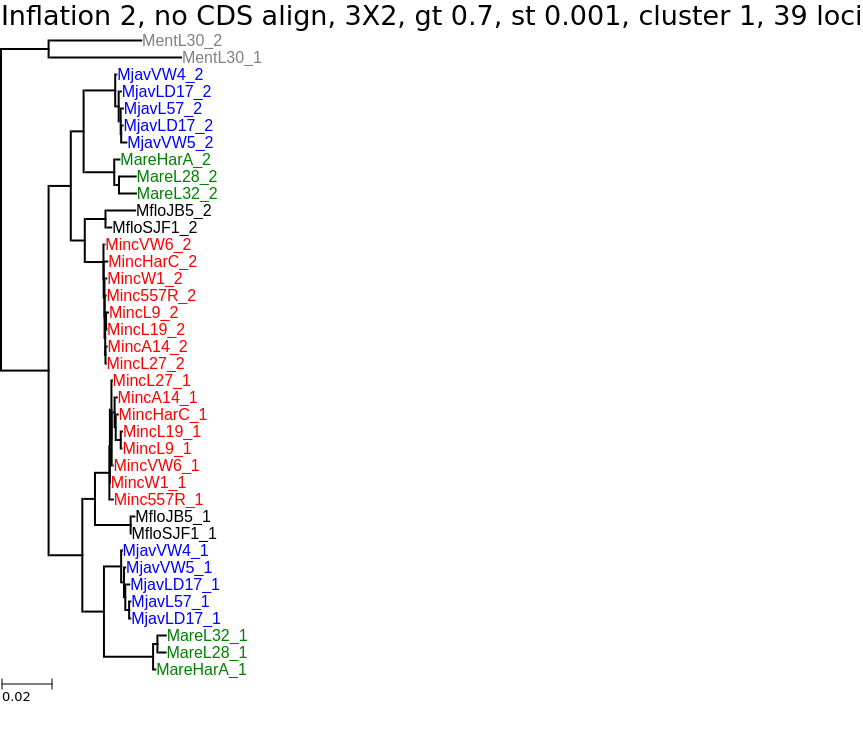

In [6]:
from IPython.display import Image
Image('./orthofinder/all_inputs/Results_Jul02/I2_3X2_gt0.7_st0.001_alns_1_4/cluster_1.png', width=800)

## 4.4 Build a thorough RAxML tree for the large cluster
Because the two cluster trees have the same topology, they can be merged

In [4]:
# rerun the tree of cluster 0
md5 = 'f2f51893cb434759411b04a1ca40a4b9ad85c46b'
matrix_from_treeCl_cache = alndir.replace('alns','cache_alignments') + '/%s.phy' % md5
parts_from_treeCl_cache = alndir.replace('alns','cache_alignments') + '/%s.partitions.txt' % md5
print matrix_from_treeCl_cache
print parts_from_treeCl_cache

/home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/Homeologue_phylogenomics/orthofinder/all_inputs/Results_Jul02/I2_3X2_gt0.7_st0.001_cache_alignments_1_4/f2f51893cb434759411b04a1ca40a4b9ad85c46b.phy
/home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/Homeologue_phylogenomics/orthofinder/all_inputs/Results_Jul02/I2_3X2_gt0.7_st0.001_cache_alignments_1_4/f2f51893cb434759411b04a1ca40a4b9ad85c46b.partitions.txt


<pre>
#!/bin/bash
#SBATCH -J raxml
#SBATCH -N 1
#SBATCH --ntasks-per-node 1
#SBATCH -o ./phylo.out
#SBATCH -e ./phylo.err
#SBATCH -p highmem
#SBATCH --exclusive


module add gcc/4.9.3

/home/my_user/standard-RAxML-master/raxmlHPC-PTHREADS-SSE3 \
-s f2f51893cb434759411b04a1ca40a4b9ad85c46b.phy \
-q f2f51893cb434759411b04a1ca40a4b9ad85c46b.partitions.txt \
-m GTRGAMMA \
-p 123 \
-N 100 \
-n f2f51893cb434759411b04a1ca40a4b9ad85c46b_0 \
-T 40 \
&& \
/home/my_user/standard-RAxML-master/raxmlHPC-PTHREADS-SSE3 \
-s f2f51893cb434759411b04a1ca40a4b9ad85c46b.phy	\
-q f2f51893cb434759411b04a1ca40a4b9ad85c46b.partitions.txt \
-m GTRGAMMA \
-b 789 \
-p 123 \
-N 100 \
-n f2f51893cb434759411b04a1ca40a4b9ad85c46b_1 \
-T 40 \
&& \
/home/my_user/standard-RAxML-master/raxmlHPC-PTHREADS-SSE3 \
-f b \
-s f2f51893cb434759411b04a1ca40a4b9ad85c46b.phy \
-t RAxML_bestTree.f2f51893cb434759411b04a1ca40a4b9ad85c46b_0 \
-z RAxML_bootstrap.f2f51893cb434759411b04a1ca40a4b9ad85c46b_1 \
-m GTRGAMMA \
-n f2f51893cb434759411b04a1ca40a4b9ad85c46b_2 \
 

module purge

</pre>

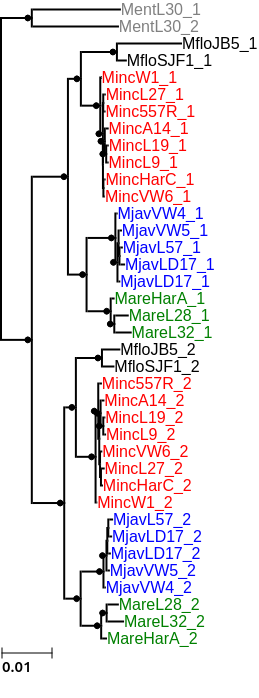

In [12]:
ns = NodeStyle()
ns['size'] = 0
ns['vt_line_width'] = 2
ns['hz_line_width'] = 2
ts = TreeStyle()
ts.show_leaf_name=False

colors = {
    'Minc':'Red',
    'Mjav':'Blue',
    'Mflo':'Black',
    'Mare':'Green',
    'Ment':'gray'
}

alndir = './orthofinder/all_inputs/Results_Jul02/I2_3X2_gt0.7_st0.001_alns_1_4'
treefile = alndir+'/RAxML_bipartitions.f2f51893cb434759411b04a1ca40a4b9ad85c46b_2'

t = Tree(treefile)
t.dist = 0
try:
    t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
except:
    t.set_outgroup('MentL30_1')

for n in t.traverse():
    if n.is_leaf():
        text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD17')

        fgcolor = 'black'
        try:
            fgcolor=colors[text[:4]]
        except:
            fgcolor = 'black'

        n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                   0,position='branch-right')
    elif n.support == 100:
        n.add_face(CircleFace(3, 'black'),0,position='float')

    n.set_style(ns)
t.render(alndir+'/raxml.png',tree_style=ts, dpi=300)
t.render('%%inline',tree_style=ts, dpi=300)

## 4.5 Shuffled raxml consensus
100 randomized supermatrices of cluster where in each gene partition, each homeologue is randomly assigned to the first or the second homeologue.

In [16]:
from Bio import SeqIO
from random import shuffle
from misc import execute_cline
from os import rename
import glob

workdir = alndir + '/raxmlshuffled'

real_seq = SeqIO.to_dict(SeqIO.parse(matrix_from_treeCl_cache,'phylip'))

with open(parts_from_treeCl_cache,'r') as lines:
    parts = []
    for line in lines:
        coords = line.rstrip().split('=')[1].strip().split('-')
        coords = [int(i) for i in coords]
        coords[0] -= 1
        parts.append(coords)

with open(workdir+'/trees.txt','wt') as all_trees:        
    repeat = 0        
    while repeat < 100:
        shuffled_dict = {key: '' for key in real_seq}
        for part in parts:
            homs = [1,2]
            shuffle(homs)
            homs = [None] + homs
            for key in shuffled_dict:
                hom_to_sample = key[:-1] + str(homs[int(key[-1])])
                shuffled_dict[key] += str(real_seq[hom_to_sample].seq)[part[0]:part[1]]

        with open(workdir + '/shuffled%i.fasta'%repeat,'wt') as hndl:
            for key in shuffled_dict:
                hndl.write('>%s\n%s\n'%(key,shuffled_dict[key]))

        raxmlcline = "raxmlHPC-PTHREADS -T 12 -s {0} -n repeat{1} -m GTRGAMMA -q {2} -p 123".format(
            workdir + '/shuffled%i.fasta'%repeat,
            repeat,
            parts_from_treeCl_cache
        )         
        out, err = execute_cline(raxmlcline)
        tree = open('RAxML_bestTree.repeat%i'%repeat,'r').read().rstrip()
        all_trees.write(tree+'\n')
        for f in glob.glob('RAxML_*'):
            rename(f, workdir + '/' +f)


        repeat += 1

In [18]:
con_cline = 'raxmlHPC-PTHREADS -J STRICT -z {0} -m GTRGAMMA -n RaxStrict'

out, err = execute_cline(con_cline.format(workdir+'/trees.txt'))


rename('RAxML_StrictConsensusTree.RaxStrict',alndir + '/RAxML_StrictConsensusTree.RaxStrict')

rename('RAxML_info.RaxStrict',alndir + '/RAxML_info.RaxStrict')

from ete2 import *   
ns = NodeStyle()
ns['size'] = 0
ns['vt_line_width'] = 2
ns['hz_line_width'] = 2
ts = TreeStyle()
#ts.title.add_face(TextFace(title, fsize=20), column=0)
ts.show_leaf_name=False

colors = {
    'Minc':'Red',
    'Mjav':'Blue',
    'Mflo':'Black',
    'Mare':'Green',
    'Ment':'gray'
}

raxmlf = './orthofinder/all_inputs/Results_Jul02/'
raxmlf += 'I2_3X2_gt0.7_st0.001_alns_1_4/RAxML_StrictConsensusTree.RaxStrict'

t = Tree(open(raxmlf,'r').read().replace('[100]',''))
t.dist = 0
try:
    t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
except:
    t.set_outgroup('MentL30_1')

for n in t.traverse():
    if n.is_leaf():
        text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD17')

        fgcolor = 'black'
        try:
            fgcolor=colors[text[:4]]
        except:
            fgcolor = 'black'

        n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                   0,position='branch-right')

    n.set_style(ns)
a=t.render(alndir+'/raxml_strict.png',tree_style=ts, dpi=300)

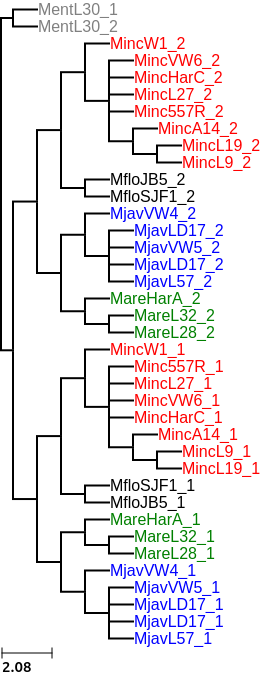

In [13]:
Image(alndir+'/raxml_strict.png')
# A strict consensus tree of all the randomized trees

## 4.6 Astral tree

In [3]:
# Make gene trees
import glob
alndir = '/home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/Homeologue_phylogenomics/'
alndir += 'orthofinder/all_inputs/Results_Jul02/I2_3X2_gt0.7_st0.001_alns_1_4'
treeglob = alndir + '/RAxML_bestTree.*'
with open(alndir+'/trees.txt','wt') as hndl:
    for f in glob.glob(treeglob):
        hndl.write(open(f,'r').read())
    

In [4]:
%%bash
# Astral tree

java -jar /home/amir/programs/ASTRAL-master/astral.4.10.6.jar \
-i /home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/\
Homeologue_phylogenomics/orthofinder/all_inputs/Results_Jul02/\
I2_3X2_gt0.7_st0.001_alns_1_4/trees.txt \
1> /home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/\
Homeologue_phylogenomics/orthofinder/all_inputs/Results_Jul02/\
I2_3X2_gt0.7_st0.001_alns_1_4/astral.out \
2> /home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/\
Homeologue_phylogenomics/orthofinder/all_inputs/Results_Jul02/\
I2_3X2_gt0.7_st0.001_alns_1_4/astral.log \

In [27]:
from ete2 import *   

ns = NodeStyle()
ns['size'] = 0
ns['vt_line_width'] = 2
ns['hz_line_width'] = 2
ts = TreeStyle()
#ts.title.add_face(TextFace(title, fsize=20), column=0)
ts.show_leaf_name=False

colors = {
    'Minc':'Red',
    'Mjav':'Blue',
    'Mflo':'Black',
    'Mare':'Green',
    'Ment':'gray'
}

astralf = './orthofinder/all_inputs/Results_Jul02/I2_3X2_gt0.7_st0.001_alns_1_4/astral.out'

t = Tree(astralf)
t.dist = 0
try:
    t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
except:
    t.set_outgroup('MentL30_1')

for n in t.traverse():
    if n.is_leaf():
        text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD17')

        fgcolor = 'black'
        try:
            fgcolor=colors[text[:4]]
        except:
            fgcolor = 'black'

        n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                   0,position='branch-right')

    n.set_style(ns)
a=t.render(alndir+'/astral.png',tree_style=ts, dpi=300)
#t.render('%%inline',tree_style=ts, dpi=300)

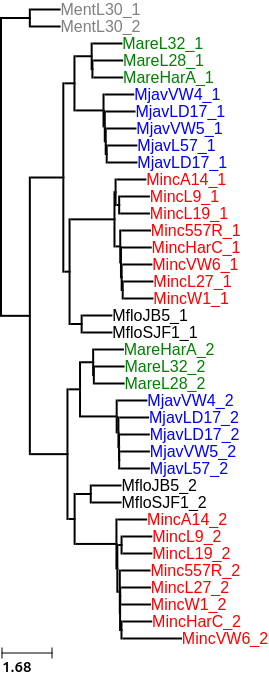

In [14]:
Image(alndir+'/astral.png')

## 4.7 Shuffeled astral consensus
Same as the randomized supermatrices, we randomize the homeologue suffix between the homeologues in the gene trees

In [32]:
from misc import makedir, execute_cline
from random import shuffle
from ete2 import Tree
import glob
from os import rename


makedir(alndir+'/astralshuffeled')
workdir = alndir+'/astralshuffeled'
treeglob = alndir + '/RAxML_bestTree.*'
astralcline = 'java -jar /home/amir/programs/ASTRAL-master/astral.4.10.6.jar '
astralcline += '-i {0}'
repeat = 0
while repeat < 100:
    astralin = workdir + '/trees%i.txt' % repeat
    with open(astralin, 'wt') as hndl:
        for f in glob.glob(treeglob):
            homs = [1,2]
            shuffle(homs)
            homs = [None] + homs
            t = Tree(f)
            for l in t:
                suffix = int(l.name[-1])
                shuffled_suffix = str(homs[suffix])
                l.name = l.name[:-1] + shuffled_suffix
            hndl.write(t.write().rstrip()+'\n')
    astralout = workdir + '/astral%i.out' % repeat
    astrallog = workdir + '/astral%i.log' % repeat
    out, err = execute_cline(astralcline.format(astralin))
    with open(astralout,'wt') as hndl:
        hndl.write(out)
    with open(astrallog,'wt') as hndl:
        hndl.write(err)
        
    repeat += 1    
    

altraltreeglob = workdir + '/astral*.out'

all_shuffled_trees = workdir + '/all_shuffled_trees.txt'
with open(all_shuffled_trees,'wt') as hndl:
    for f in glob.glob(altraltreeglob):
        hndl.write(open(f,'r').read())
        
con_cline = 'raxmlHPC-PTHREADS -J STRICT -z {0} -m GTRGAMMA -n AstStrict'

out, err = execute_cline(con_cline.format(all_shuffled_trees))


rename('RAxML_StrictConsensusTree.AstStrict',alndir + '/RAxML_StrictConsensusTree.AstStrict')

rename('RAxML_info.AstStrict',alndir + '/RAxML_info.AstStrict')

from ete2 import *   
ns = NodeStyle()
ns['size'] = 0
ns['vt_line_width'] = 2
ns['hz_line_width'] = 2
ts = TreeStyle()
#ts.title.add_face(TextFace(title, fsize=20), column=0)
ts.show_leaf_name=False

colors = {
    'Minc':'Red',
    'Mjav':'Blue',
    'Mflo':'Black',
    'Mare':'Green',
    'Ment':'gray'
}

astralf = './orthofinder/all_inputs/Results_Jul02/'
astralf += 'I2_3X2_gt0.7_st0.001_alns_1_4/RAxML_StrictConsensusTree.AstStrict'

t = Tree(open(astralf,'r').read().replace('[100]',''))
t.dist = 0
try:
    t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
except:
    t.set_outgroup('MentL30_1')

for n in t.traverse():
    if n.is_leaf():
        text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD17')

        fgcolor = 'black'
        try:
            fgcolor=colors[text[:4]]
        except:
            fgcolor = 'black'

        n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                   0,position='branch-right')

    n.set_style(ns)
a=t.render(alndir+'/astral_strict.png',tree_style=ts, dpi=300)
#t.render('%%inline',tree_style=ts, dpi=300)

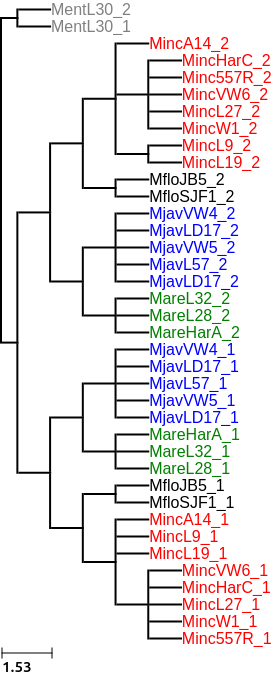

In [15]:
Image(alndir+'/astral_strict.png')

In [16]:
from ast import literal_eval
from collections import Counter
from Bio import SeqIO

loci_txt = './orthofinder/all_inputs/Results_Jul02/I2_3X2_gt0.7_st0.001_alns_1_4/loci.txt'
all_loci = literal_eval(open(loci_txt,'r').read())
loci = all_loci[0] + all_loci[1]

f = './orthofinder/all_inputs/Results_Jul02/I2_3X2_gt0.7_st0.001_alns_1_4/%s.1.fasta'

occupancy = {}

MfloSJF1_1 = 0
MfloSJF1_2 = 0

for locus in loci:
    leaves = [r.id.split('_')[0] for r in SeqIO.parse(f%locus,'fasta')]
    counter = Counter(leaves)
    combo = 'flo%iare%ijav%iinc%i'%(counter['MfloSJF1'],
                                    counter['MareHarA'],
                                    counter['MjavVW4'],
                                    counter['MincW1'])
    if counter['MfloSJF1'] == 1:
        if 'MfloSJF1_1' in [r.id for r in SeqIO.parse(f%locus,'fasta')]:
            MfloSJF1_1 += 1
        elif 'MfloSJF1_2' in [r.id for r in SeqIO.parse(f%locus,'fasta')]:
            MfloSJF1_2 += 1
    
    try:
        occupancy[combo] += 1
    except:
        occupancy[combo] = 1
print occupancy
print MfloSJF1_1, MfloSJF1_2

{'flo2are2jav2inc2': 4, 'flo2are2jav2inc1': 5, 'flo1are2jav1inc2': 45, 'flo2are2jav1inc1': 3, 'flo2are2jav1inc2': 7, 'flo2are1jav1inc2': 8, 'flo1are2jav2inc1': 83, 'flo1are2jav2inc2': 214, 'flo1are1jav2inc2': 63, 'flo2are1jav2inc1': 6, 'flo2are1jav2inc2': 7}
176 229
